# Kepler | Star classification
*Anaelle JAFFRÉ, Guénaël ROGER*

This Jupyter Notebook is a report refering to an experimental project. It aims to discover an application of Echo State Networks (ESN) throughout the [Exoplanet Hunting in Deep Space](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data?resource=download) dataset.

## Objective

The final objective of this project is to classify the stars of the dataset, depending on if they do have an exoplanet in their system of not.

Additionally, a transit prediction can be added as a second objective.

## Base library: reservoirpy

The main library we use in this project, to train the model, is [reservoirpy](https://github.com/reservoirpy/reservoirpy). It is a simple and flexible library for Reservoir Computing architectures like Echo State Networks. It is developped and supported by [Inria](https://www.inria.fr/en).

## Global methodology

We have time series representing measurements of the brightness of stars over time. The ESN studies slow variations, flux drops, noise and recurring patterns in order to determine whether or not there is a transit (presence of an exoplanet). If this works, the ESN will be adapted to enable transit prediction (bonus).

## Program

In this Jupyter Notebook, a first basic version of the program is set. The ESN is initialized with base parameters, which should be optimized. This will be made in a second time. These experiments will be available in the other Jupiter Notebooks of the project.

### Imports

To run the experiment, some fundamental packages are needed, such as `numpy` of `pandas` libraries. The most important package imported here is `reservoirpy`.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from pathlib import Path

import reservoirpy as rpy
from reservoirpy.nodes import Reservoir, Ridge

from sklearn.metrics import accuracy_score, roc_auc_score


### Dataset

We are using the [Exoplanet Hunting in Deep Space](https://www.kaggle.com/datasets/keplersmachines/kepler-labelled-time-series-data?resource=download) dataset which contains information about "the change in flux (light sensitivity) of several thousand stars". Each star is labelized according to the presence or not of exoplanet.

To begin, the dataset is divided in two parts: one for the traning, one for the tests.

In [3]:
DATA_PATH = Path("../data")

train_df = pd.read_csv(DATA_PATH / "exoTrain.csv")
test_df  = pd.read_csv(DATA_PATH / "exoTest.csv")

print(train_df["LABEL"].value_counts())
print(test_df["LABEL"].value_counts())

LABEL
1    5050
2      37
Name: count, dtype: int64
LABEL
1    565
2      5
Name: count, dtype: int64


The training dataset is composed of 5087 entries, in which 37 are stars with exoplanets.

The testing dataset is composed of 570 entries, in which 5 are stars with exoplanets.

Having such a difference between the two classes can cause some issues. Such impact will be discussed in the conclusion.

#### Labelling

In the dataset, a label of "1" means the star does not have an expoplanet, while a label of "2" means the star has at least one exoplanet.

For clearer comprehension, we will substract 1 to these values, so that "**0**" means **no exoplanet** and "**1**" means the **existence of an exoplanet**.

#### X/y separation

By convention, column 0 contains the labels. The rest are the time series.

In [18]:
X_train = train_df.iloc[:, 1:].values
X_test = test_df.iloc[:, 1:].values

y_train_np = np.asarray(train_df.iloc[:, 0], dtype=int) - 1
y_test_np  = np.asarray(test_df.iloc[:, 0], dtype=int) - 1

Note: here, we substract 1 from the labels to fit the previous decision.

General statistics

In [5]:
print(f"Mean = {round(X_train.mean(), 2)}, \nStandard deviation = {round(X_train.std(), 2)}")

Mean = 130.42, 
Standard deviation = 22072.21


The mean luminous flux does not seem to have any sense, as the standard deviation explodes. Hence, if the series are not normalized, the ESN will not percieve the structure of the series and will not be able to detect an exoplanet correctly.

#### Visualization

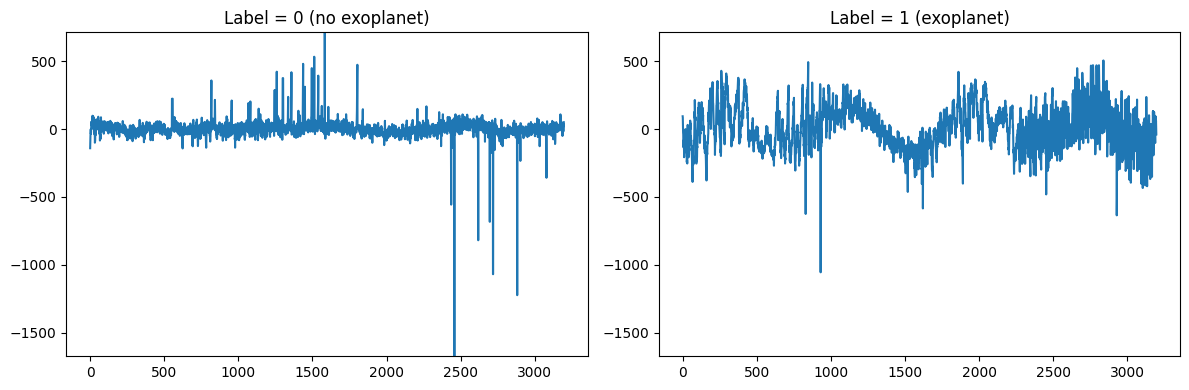

In [19]:
# indices of the 2 classes
idx_no  = np.where(y_train_np == 0)[0][0]
idx_yes = np.where(y_train_np == 1)[0][0]

ymin = min(X_train[idx_no].min(), X_train[idx_yes].min())
ymax = max(X_train[idx_no].max(), X_train[idx_yes].max())

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(X_train[idx_no])
plt.ylim(ymin, ymax)
plt.title("Label = 0 (no exoplanet)")

plt.subplot(1, 2, 2)
plt.plot(X_train[idx_yes])
plt.ylim(ymin, ymax)
plt.title("Label = 1 (exoplanet)")

plt.tight_layout()
plt.show()


Here is an instance of the time serie of the luminous flux of a star. Its label is 1, which means it does have an exoplanet.

It is difficultly perceivable on these examples, but when there is an exoplanet, a dirac-like bar is repeated regularly.

#### Formatting

The shape of time series is formatted for the ESN.

In [20]:
X_train = X_train[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

# Sequences
X_train_seq = [x for x in X_train]
X_test_seq  = [x for x in X_test]

# Verify the shape of X: must be (n, 1)
print("X shape = ", X_train_seq[0].shape)

# Reshape y
y_train_seq = [
    np.full((x.shape[0], 1), y)
    for x, y in zip(X_train_seq, y_train_np)
]

y_test_seq = [
    np.full((x.shape[0], 1), y)
    for x, y in zip(X_test_seq, y_test_np)
]

# Verify the shape of y: must be (n, 1)
print("y shape = ", y_train_seq[0].shape)

# Normalisation
mean = np.mean(X_train)
std  = np.std(X_train)

X_train_seq = [(x - x.mean()) / (x.std() + 1e-8) for x in X_train_seq]
X_test_seq  = [(x - x.mean()) / (x.std() + 1e-8) for x in X_test_seq]

# Verifications
print("Mean = ", round(X_train_seq[0].mean(), 11))  # Must be close to 0
print("Standard deviation = ", round(X_train_seq[0].std(), 11))   # Must be close to 1


X shape =  (3197, 1)
y shape =  (3197, 1)
Mean =  0.0
Standard deviation =  0.99999999994


It can be confirmed that the columns do have the right shapes.

Moreover, after normalization, the mean can be approximated by 0 and the standard deviation by 1. The dataset is now ready for the ESN.

### ESN

The Echo State Network is put in place here.

#### Seed

First, a seed is defined to keep the same reservoir for the training.

In [22]:
np.random.seed(42)
random.seed(42)

#### Parameters

To begin, base parameters are set. They will be optimized in a second part.

Note: we choose a small number of neurons to avoid long-term calculations.

In [21]:
units = 20
leak_rate = 0.3
input_scaling = 0.5
spectral_radius = 0.9
ridge = 1e-6

Then, the reservoir architecture is put in place, thanks to the `reservoirpy` library.

In [23]:
reservoir = Reservoir(
    units=units,
    lr=leak_rate,
    input_scaling=input_scaling,
    sr=spectral_radius
)

readout = Ridge(ridge=ridge)

esn = reservoir >> readout

### Training and Evaluation

In [26]:
# Create sequence labels for ESN
y_train_seq_np = [np.full((x.shape[0], 1), y) for x, y in zip(X_train_seq, y_train_np)] # Each timestep gets the same label (shape: timesteps x 1)

# Training
esn.fit(X_train_seq, y_train_seq_np)

# Prediction
y_pred_seq = esn.run(X_test_seq)  # returns one sequence per series
y_pred = np.array([yp.mean() for yp in y_pred_seq])  # aggregate per series
y_pred_label = (y_pred > 0.5).astype(int)

# Evaluation
accuracy = accuracy_score(y_test_np, y_pred_label)
auc = roc_auc_score(y_test_np, y_pred)

print(f"Accuracy = {accuracy},\nArea Under the ROC Curve = {auc}")

# Errors indices
errors = np.where(y_test_np != y_pred_label)[0]
print(f"Number of errors: {len(errors)} on {len(y_test_np)}")

Accuracy = 0.9912280701754386,
Area Under the ROC Curve = 0.7093805309734513
Number of errors: 5 on 570


At  the end of the training, the model can be evaluated thanks to its accuracy score and the Area Under the ROC Curve (AUC) score.

The **accuracy** represents how much the model fits the expectations. The higher the better.

The ROC curve (Receiver Operating Characteristic) plots *True Positive Rate* versus *False Positive Rate* at different thresholds. The **AUC** is a number summarizing the ability of the model to separate the two classes. An AUC of 1 means a perfect separation, while an AUC of 0.5 signifies a random guessing.

Finally, the real label of the first 10 **errors** is printed, to see what kind of errors does the ESN do.

### Results

As a recall, for this first experiment, here are the parameters that have been initialized:
```
units = 20
leak_rate = 0.3
input_scaling = 0.5
spectral_radius = 0.9
ridge = 1e-6
```

When the ESN is first trained on these base parameters, the following results are obtained: 
1. Accuracy = 99%
2. AUC = 0.7
3. Errors = 5 on 570

At first view, these results do really seem great. The accuracy is really high, so the model almost never fails. Moreover, it does not answer randomly, although the AUC value could be enhanced.

However, there are 5 errors.

5 is exactly the number of stars with exoplanets series of the testing dataset. Which means: in fact, the model always predicted a *no explanet* star, even when it was a star with an exoplanet.

In conclusion: although the first statistics seem great, the model **totally failed** to detect stars with an exoplanet.

#### Visualization

It could be interestinf to visualize 5 errors and 5 correct guesses.

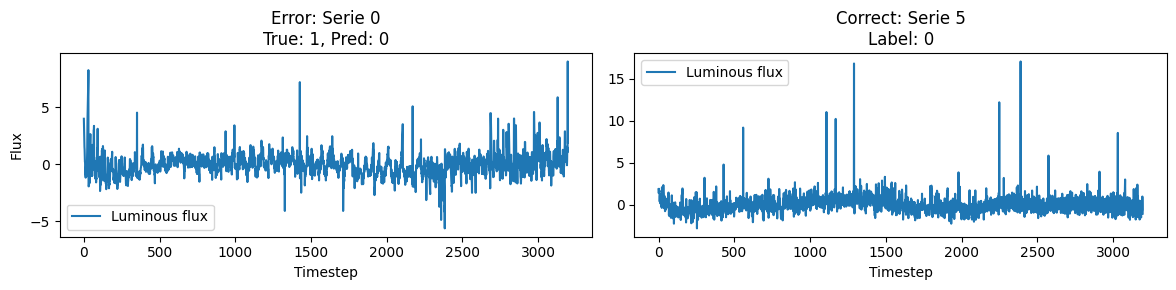

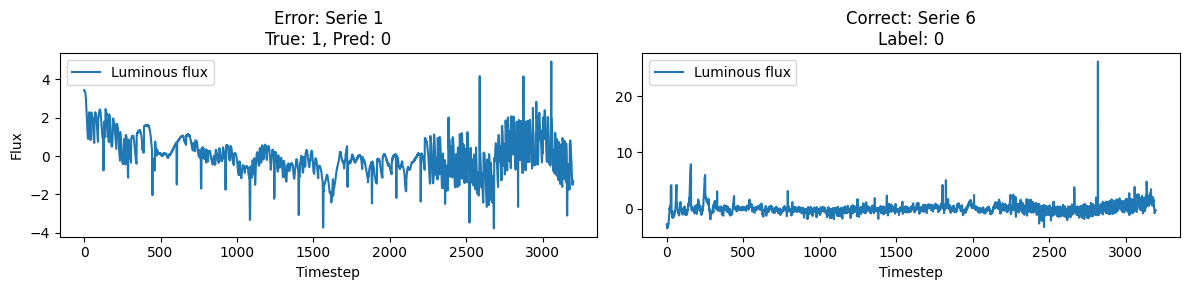

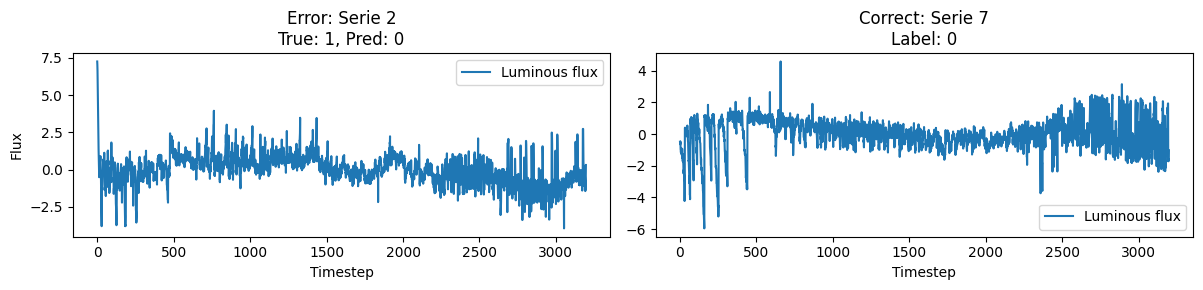

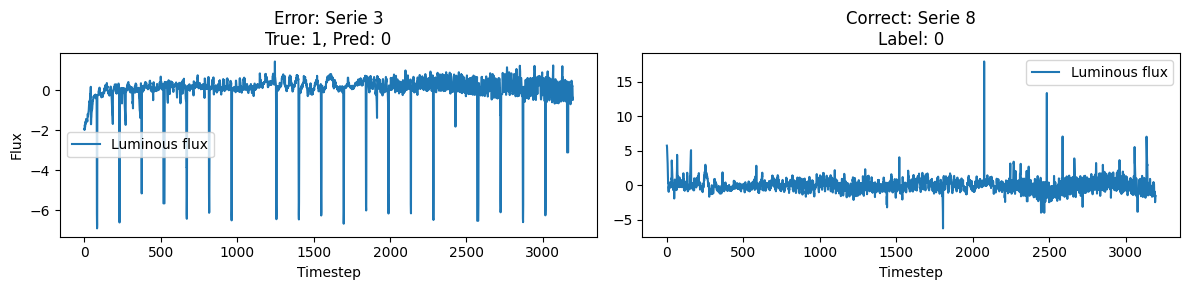

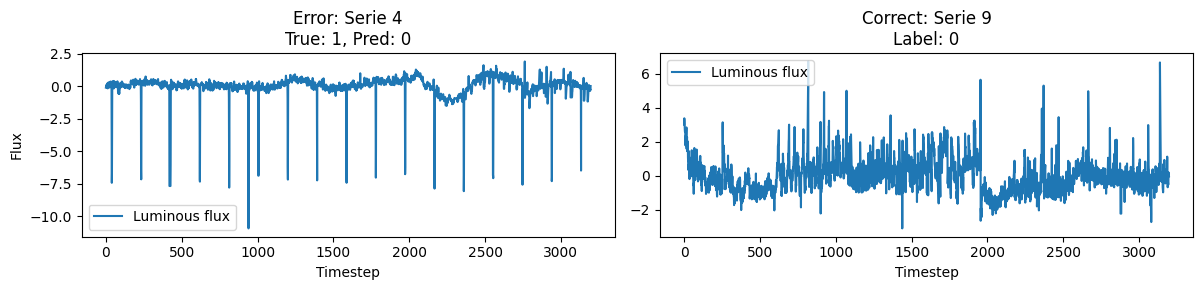

In [27]:
correct = np.where(y_test_np == y_pred_label)[0]

n = 5
for e, c in zip(errors[:n], correct[:n]):
    plt.figure(figsize=(12, 3))

    # Errors
    plt.subplot(1, 2, 1)
    plt.plot(X_test_seq[e].squeeze(), label="Luminous flux")
    plt.title(f"Error: Serie {e}\nTrue: {y_test_np[e]}, Pred: {y_pred_label[e]}")
    plt.xlabel("Timestep")
    plt.ylabel("Flux")
    plt.legend()

    # Correct guesses
    plt.subplot(1, 2, 2)
    plt.plot(X_test_seq[c].squeeze(), label="Luminous flux")
    plt.title(f"Correct: Serie {c}\nLabel: {y_test_np[c]}")
    plt.xlabel("Timestep")
    plt.legend()

    plt.tight_layout()
    plt.show()

## Conclusion

This first experiment suggests that the imbalance in the dataset can cause the model to fail. It fails to predict stars with an exoplanet, which can be explained by the lack of star with exoplanet series in the training dataset.

In the other experiments, parameters will be fine-tuned, to try to avoid the impact of this lack of data and leverage its full potential.